In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
get_ipython().run_line_magic('matplotlib', 'inline')
 
from torch import nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
 
 

In [2]:
time_step=2         #时间间隔
epoch=501             #循环次数
input_size=3          #输入数据维度
output_size=1        #输出数据维度
mid_dim=8           #中间层数维度
mid_layers=1      #中间层数目

 
 

In [3]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super().__init__()
 
        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers,batch_first=True)     #构建LSTM层
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),                                       #构建全连接层
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim)) 
 
    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)
 
        batch_size, seq_len, hid_dim = y.shape
        y = y.reshape(-1, hid_dim)
        y = self.reg(y)            #这里进行结构重整因为矩阵只能进行二维的数据变换
        y = y.reshape(batch_size, seq_len,-1)
        return y
 
 

In [4]:
 
def load_data():
    seq_number=np.array(
        [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
         209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
         272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
         302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
         315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
         318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
         348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
         362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
         342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
         417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
         432.],dtype=np.float32
    )
    seq_number=seq_number[:,np.newaxis]
    seq_year=np.arange(12)
    seq_month=np.arange(12)
    seq_year_month=np.transpose(
    [
        np.repeat(seq_year,len(seq_month)),
        np.tile(seq_month,len(seq_year)),
    ]
    )
    seq=np.concatenate((seq_number,seq_year_month),axis=1)
    
    seq=(seq-seq.mean(axis=0))/seq.std(axis=0)
    return(seq)
 
 

In [5]:
data=load_data()
train_data,test_data = train_test_split(data,train_size=0.7)

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")    #定义一个设备
train_data=torch.tensor(train_data,dtype=torch.float32,device=device)

In [7]:
data_sample = train_data.reshape(-1,time_step,input_size)
label_sample = train_data[:,0]
label_sample = label_sample.reshape(-1,time_step,1)
label_sample.shape

torch.Size([50, 2, 1])

In [8]:
label_sample.shape

torch.Size([50, 2, 1])

In [9]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")    #定义一个设备
net=RegLSTM(input_size,output_size,mid_dim,mid_layers).to(device)   #实例化神经网络
criterion=nn.MSELoss()                                                  #定义一个损失函数
optimizer=torch.optim.Adam(net.parameters(),lr=1e-2)                    #定义一个优化器

In [10]:
net.train()
for i in range(epoch):
    for j in range(data_sample.shape[0]):
        train_x=data_sample[[j],:,:]
        train_y=label_sample[[j],:,:]

        
        out = net(train_x)
        loss=criterion(out,train_y)
        #loss = criterion(out[:,-1,:], var_y[:,-1,:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    if i%100==0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(i, loss.item()))
 
 

Epoch:    0, Loss: 0.18796
Epoch:  100, Loss: 0.00271
Epoch:  200, Loss: 0.00037
Epoch:  300, Loss: 0.00018
Epoch:  400, Loss: 0.00053
Epoch:  500, Loss: 0.00018


In [11]:
test_data=torch.tensor(test_data,dtype=torch.float32,device=device)

In [12]:
test_x = test_data.reshape(-1,1,input_size)
test_y = test_data[:,0]
test_y = test_y.reshape(-1,1,1)
test_x.shape

torch.Size([44, 1, 3])

In [13]:
y_pred = []
for i in range(test_x.shape[0]):
    tem=net(test_x[[i],:,:]).cpu().data.numpy()
    y_pred.append(tem[0][0])
y_pred

[array([0.22853391], dtype=float32),
 array([-0.3926428], dtype=float32),
 array([-1.1375216], dtype=float32),
 array([-0.5866276], dtype=float32),
 array([0.78618515], dtype=float32),
 array([-1.281844], dtype=float32),
 array([0.6523607], dtype=float32),
 array([-0.6466329], dtype=float32),
 array([0.24600637], dtype=float32),
 array([0.55603456], dtype=float32),
 array([-0.02346268], dtype=float32),
 array([-1.3880727], dtype=float32),
 array([1.0594821], dtype=float32),
 array([0.56483954], dtype=float32),
 array([1.167619], dtype=float32),
 array([1.0922353], dtype=float32),
 array([0.30569702], dtype=float32),
 array([-1.1147063], dtype=float32),
 array([-1.3710945], dtype=float32),
 array([0.3071816], dtype=float32),
 array([-0.8164114], dtype=float32),
 array([0.6221598], dtype=float32),
 array([-1.1039807], dtype=float32),
 array([1.1859951], dtype=float32),
 array([-0.42964202], dtype=float32),
 array([-0.11483163], dtype=float32),
 array([0.56329924], dtype=float32),
 array(

In [14]:
test_y = test_y.reshape(-1,1)

In [15]:
test_y = test_y.cpu().numpy()
test_y

array([[ 0.2066214 ],
       [-0.37891236],
       [-1.1317415 ],
       [-0.5796668 ],
       [ 0.7837904 ],
       [-1.2655778 ],
       [ 0.6583189 ],
       [-0.6382202 ],
       [ 0.21498616],
       [ 0.5579416 ],
       [-0.02759212],
       [-1.3826846 ],
       [ 1.0347334 ],
       [ 0.5663064 ],
       [ 1.1434754 ],
       [ 1.0598277 ],
       [ 0.29026908],
       [-1.1066471 ],
       [-1.3575902 ],
       [ 0.31536338],
       [-0.8055155 ],
       [ 0.6248598 ],
       [-1.0982825 ],
       [ 1.1685697 ],
       [-0.429101  ],
       [-0.1112398 ],
       [ 0.5663064 ],
       [-0.42073622],
       [-0.7469622 ],
       [-0.77205646],
       [-0.9142575 ],
       [-1.1233767 ],
       [ 2.8582528 ],
       [ 1.7624682 ],
       [ 0.49938828],
       [ 0.6666836 ],
       [-0.5963963 ],
       [ 0.26517478],
       [ 1.6035377 ],
       [ 1.6035377 ],
       [-1.2153891 ],
       [ 0.69177794],
       [ 2.130518  ],
       [ 0.47429398]], dtype=float32)

In [16]:
y_pred = np.array(y_pred).reshape((-1,1))
y_pred

array([[ 0.22853391],
       [-0.3926428 ],
       [-1.1375216 ],
       [-0.5866276 ],
       [ 0.78618515],
       [-1.281844  ],
       [ 0.6523607 ],
       [-0.6466329 ],
       [ 0.24600637],
       [ 0.55603456],
       [-0.02346268],
       [-1.3880727 ],
       [ 1.0594821 ],
       [ 0.56483954],
       [ 1.167619  ],
       [ 1.0922353 ],
       [ 0.30569702],
       [-1.1147063 ],
       [-1.3710945 ],
       [ 0.3071816 ],
       [-0.8164114 ],
       [ 0.6221598 ],
       [-1.1039807 ],
       [ 1.1859951 ],
       [-0.42964202],
       [-0.11483163],
       [ 0.56329924],
       [-0.42891026],
       [-0.756647  ],
       [-0.7829864 ],
       [-0.92363036],
       [-1.120847  ],
       [ 2.879778  ],
       [ 1.758767  ],
       [ 0.5229007 ],
       [ 0.70033616],
       [-0.60579354],
       [ 0.27574757],
       [ 1.6125689 ],
       [ 1.6058425 ],
       [-1.2231067 ],
       [ 0.6924441 ],
       [ 2.1762972 ],
       [ 0.4866848 ]], dtype=float32)

In [17]:
diff = test_y - y_pred

L1:0.012    L2:0.000


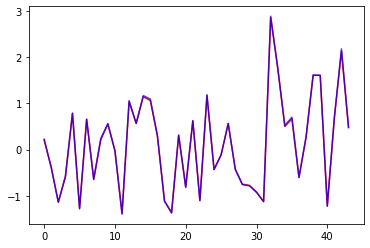

In [18]:

l1_loss=np.mean(np.abs(diff))
l2_loss=np.mean(diff**2)
print("L1:{:.3f}    L2:{:.3f}".format(l1_loss,l2_loss))
plt.plot(test_y, 'r', label='pred')
plt.plot(y_pred, 'b', label='real', alpha=0.7)
 


In [19]:
a=np.array([1,2,3])
b=np.array([2,2,4])
 

In [20]:
np.corrcoef(a,b)
 

array([[1.       , 0.8660254],
       [0.8660254, 1.       ]])